# Root growth

One of the most important and difficult components of crop models is root growth. Compared to the overwhelming amount of observations and models for above ground vegetation, the information about root growth along the soil profile is fairly limited. Generating accurate estimates of root growth (root length and root distribution) is essential for an accurate computation of the soil water and fertility balance.

Simple root growth model generate estimates of the bulk extent of the root zone in one dimension. More sophistaced root growth models can incoporate a more detailed representation of the root system based on branching patterns, root architecture, and properties of the growing medium.

In this exercise we will implement a simple model as a function of temperature in terms of thermal time (a.k.a. growing-degree days). The model is used in the Aquacrop simulation model and is as follows (Eq. 12 in Steduto et al., 2009):

$$ Z_{TT} = Z_o + (Z_x - Z_o) \sqrt[n]{ \frac{TT-\frac{1}{2}TT_o}{TT_x-\frac{1}{2}TT_o} }$$

$Z$ is the root depth at thermal time *TT*

$Z_o$ is the sowing depth

$Z_x$ is the maximum rooting length

$TT$ is the thermal time

$TT_o$ is the thermal time required until emergence

$TT_x$ is the thermal time required until maximum root length

$n$ is a parameter describing the shape of the root growth curve


## Model assumptions

- Root growth only depends on temperature. This is certainly far from reality in the sense that soil moisture, soil nutrients, and soil penetration resistance exhert an important control on root growth.

- Root development starts before crop emergence. More precisely, root growth is assumed to start half way in terms of thermal time between planting and emergence. This is about right since the first seminal roots appear before the coleoptile or cotiledons appear above the soil surface.


In [7]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# Import data
data = pd.read_csv('../datasets/gypsum_ks_daily_2018.csv')
data.head()


,TIMESTAMP,STATION,PRESSUREAVG,PRESSUREMAX,PRESSUREMIN,SLPAVG,TEMP2MAVG,TEMP2MMIN,TEMP2MMAX,TEMP10MAVG,...,SOILTMP10MAX,SOILTMP10MIN,SOILTMP5AVG655,SOILTMP10AVG655,SOILTMP20AVG655,SOILTMP50AVG655,VWC5CM,VWC10CM,VWC20CM,VWC50CM
0,1/1/18 0:00,Gypsum,99.44,100.03,98.73,104.44,-15.15,-19.56,-11.00,-15.31,...,-1.18,-2.45,-1.33,-1.14,0.74,3.50,0.1377,0.1167,0.2665,0.2203
1,1/2/18 0:00,Gypsum,99.79,100.14,99.40,104.88,-16.48,-22.10,-10.40,-16.38,...,-1.56,-3.46,-2.10,-1.82,0.28,3.13,0.1234,0.1021,0.2642,0.2196
2,1/3/18 0:00,Gypsum,98.87,99.52,97.94,103.81,-11.03,-20.64,-2.71,-10.66,...,-1.49,-3.61,-2.21,-1.93,-0.08,2.76,0.1206,0.0965,0.2353,0.2189
3,1/4/18 0:00,Gypsum,98.22,98.54,97.90,102.99,-5.83,-11.79,0.24,-5.01,...,-0.98,-2.67,-1.60,-1.46,-0.21,2.45,0.1235,0.0973,0.2094,0.2182
4,1/5/18 0:00,Gypsum,98.10,98.42,97.75,102.88,-4.73,-14.22,5.36,-4.23,...,-0.72,-2.81,-1.54,-1.38,-0.25,2.25,0.1249,0.0976,0.2047,0.2180


In [9]:
# Convert timestamps into pandas datetime
data["TIMESTAMP"] = pd.to_datetime(data["TIMESTAMP"])


In [10]:
# Compute and add day of year to dataframe
data.insert(1,'DOY',data["TIMESTAMP"].dt.dayofyear)
data.head()


,TIMESTAMP,DOY,STATION,PRESSUREAVG,PRESSUREMAX,PRESSUREMIN,SLPAVG,TEMP2MAVG,TEMP2MMIN,TEMP2MMAX,...,SOILTMP10MAX,SOILTMP10MIN,SOILTMP5AVG655,SOILTMP10AVG655,SOILTMP20AVG655,SOILTMP50AVG655,VWC5CM,VWC10CM,VWC20CM,VWC50CM
0,2018-01-01,1,Gypsum,99.44,100.03,98.73,104.44,-15.15,-19.56,-11.00,...,-1.18,-2.45,-1.33,-1.14,0.74,3.50,0.1377,0.1167,0.2665,0.2203
1,2018-01-02,2,Gypsum,99.79,100.14,99.40,104.88,-16.48,-22.10,-10.40,...,-1.56,-3.46,-2.10,-1.82,0.28,3.13,0.1234,0.1021,0.2642,0.2196
2,2018-01-03,3,Gypsum,98.87,99.52,97.94,103.81,-11.03,-20.64,-2.71,...,-1.49,-3.61,-2.21,-1.93,-0.08,2.76,0.1206,0.0965,0.2353,0.2189
3,2018-01-04,4,Gypsum,98.22,98.54,97.90,102.99,-5.83,-11.79,0.24,...,-0.98,-2.67,-1.60,-1.46,-0.21,2.45,0.1235,0.0973,0.2094,0.2182
4,2018-01-05,5,Gypsum,98.10,98.42,97.75,102.88,-4.73,-14.22,5.36,...,-0.72,-2.81,-1.54,-1.38,-0.25,2.25,0.1249,0.0976,0.2047,0.2180


In [11]:
planting_doy = 100 # About April 1
crop_season_length = 110 # days 
harvest_doy = planting_doy + crop_season_length + 1

idx_growing_season = (data["DOY"] > planting_doy) & (data["DOY"] < harvest_doy)
data = data.loc[idx_growing_season,:]
data.head()


,TIMESTAMP,DOY,STATION,PRESSUREAVG,PRESSUREMAX,PRESSUREMIN,SLPAVG,TEMP2MAVG,TEMP2MMIN,TEMP2MMAX,...,SOILTMP10MAX,SOILTMP10MIN,SOILTMP5AVG655,SOILTMP10AVG655,SOILTMP20AVG655,SOILTMP50AVG655,VWC5CM,VWC10CM,VWC20CM,VWC50CM
100,2018-04-11,101,Gypsum,97.72,98.38,96.88,102.27,8.83,-6.67,23.80,...,11.59,4.80,7.97,7.87,7.61,7.91,0.1684,0.1610,0.2495,0.2116
101,2018-04-12,102,Gypsum,96.43,97.09,95.90,100.74,18.63,8.78,28.30,...,13.85,8.74,11.19,10.78,9.43,8.34,0.1705,0.1614,0.2519,0.2116
102,2018-04-13,103,Gypsum,95.44,96.09,94.74,99.63,22.00,8.04,30.96,...,16.97,11.38,14.26,13.69,11.59,9.33,0.1723,0.1618,0.2548,0.2127
103,2018-04-14,104,Gypsum,95.18,96.07,94.60,99.37,16.31,2.06,23.92,...,18.60,14.49,16.27,15.78,13.85,10.71,0.1727,0.1608,0.2577,0.2143
104,2018-04-15,105,Gypsum,96.54,97.37,95.81,101.09,-0.41,-2.50,2.67,...,14.49,7.38,10.59,10.76,12.29,11.59,0.1655,0.1526,0.2544,0.2152


In [12]:
# Define function

def rootgrowth(par,T):
    
    # Pre-allocate variables
    TT = np.ones(len(T)) * np.nan
    TT_cum = np.ones(len(T)) * np.nan  
    root_depth = np.ones(len(T)) * np.nan 

    # Initial conditions
    TT[0] = T[0]
    TT_cum[0] = TT[0]
    root_depth[0] = par["Zsowing"]

    for i in range(1,len(T)):

        # Compute thermal time based on temeprature
        TT_step = np.maximum(T[i] - par['Tbase'], 0)
        TT[i] = TT_step
        TT_cum[i] = TT_cum[i-1] + TT_step

        # Compute root growth
        TTradical = np.maximum(TT_cum[i] - par['TTemerge']/2, 0) / (par['TTmax'] - par['TTemerge']/2)
        root_depth[i] = np.minimum(par['Zsowing'] + (par['Zmax'] - par['Zsowing']) * TTradical**par['Zshape'], par['Zmax'])

    return dict({"root_depth":root_depth, "TT":TT, "TT_cum":TT_cum})



In [13]:
# Invoke function
par = {'TTemerge':100,
       'TTmax':1000,
       'Zsowing':5,
       'Zmax':200,
       'Tbase':10,
       'Zshape':0.5}

Z = rootgrowth(par,data.TEMP2MAVG.values)


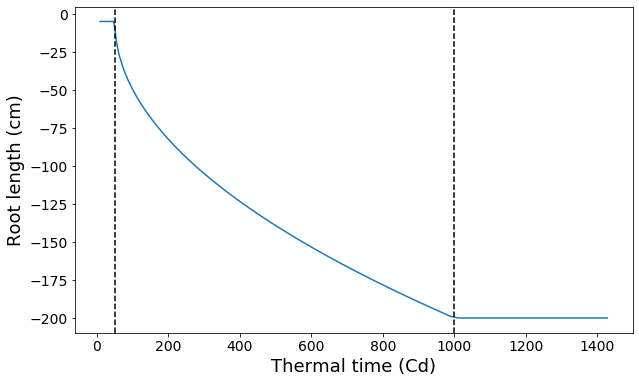

In [14]:
plt.figure(figsize=(10,6))
plt.plot(Z["TT_cum"], Z["root_depth"]*-1)
plt.axvline(par["TTemerge"]/2, color='k', linestyle='--')
plt.axvline(par["TTmax"], color='k', linestyle='--')
plt.xlabel("Thermal time (Cd)", size=18)
plt.ylabel("Root length (cm)", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


## References

Steduto, P., Hsiao, T.C., Raes, D. and Fereres, E., 2009. AquaCrop—The FAO crop model to simulate yield response to water: I. Concepts and underlying principles. Agronomy Journal, 101(3), pp.426-437.